In [2]:
import ta
import numpy as np
import pandas as pd
import random

import warnings
# Turn off all warnings
warnings.filterwarnings("ignore")

In [3]:
import ccxt
import pandas as pd
import re
import random

# Fetch OHLCV data from Kraken
def fetch_ohlcv_data(start_date, limit=None):
    exchange = ccxt.kraken()
    symbol = 'BTC/AUD'
    timeframe = '1d'
    since = exchange.parse8601(start_date)
    ohlcv_data = exchange.fetch_ohlcv(symbol, timeframe, since, limit=limit)
    
    # Convert the data to a Pandas DataFrame and set column names
    ohlcv_df = pd.DataFrame(ohlcv_data, columns=['timestamp', 'o', 'h', 'l', 'c', 'v'])
    # Convert the timestamp to a human-readable datetime format
    ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'], unit='ms')

    return ohlcv_df

origin_ohlcv_data = fetch_ohlcv_data("2021-01-01T00:00:00Z")

print(origin_ohlcv_data[:3])

   timestamp        o        h        l        c          v
0 2021-05-17  59974.1  60193.9  54452.0  55863.5  39.069198
1 2021-05-18  56175.5  58914.0  54331.0  55151.4  35.232002
2 2021-05-19  55101.3  55866.0  40250.0  48251.1  83.740528


In [4]:
ohlcv_data = origin_ohlcv_data.copy()

In [5]:
from ta.volatility import BollingerBands
from ta.volatility import AverageTrueRange
from ta.volatility import KeltnerChannel
from ta.volatility import DonchianChannel
from ta.momentum import RSIIndicator
from ta.momentum import StochasticOscillator
from ta.momentum import ROCIndicator
from ta.momentum import AwesomeOscillatorIndicator
from ta.momentum import KAMAIndicator
from ta.momentum import PercentagePriceOscillator
from ta.trend import SMAIndicator, MACD
from ta.trend import EMAIndicator
from ta.trend import PSARIndicator
from ta.trend import CCIIndicator
from ta.trend import ADXIndicator
from ta.trend import AroonIndicator
from ta.trend import DPOIndicator
from ta.trend import KSTIndicator
from ta.trend import MassIndex
from ta.trend import STCIndicator
from ta.trend import TRIXIndicator
from ta.trend import VortexIndicator
from ta.trend import WMAIndicator
from ta.volume import OnBalanceVolumeIndicator
from ta.volume import MFIIndicator

# TA Volatility



# TA Momentum

def awesome_oscillator(data, window1=5, window2=34):
    ao_string = f"ao_{window1}_{window2}"
    if ao_string in data.columns:
        return ao_string
    ao_indicator = AwesomeOscillatorIndicator(data['h'], data['l'], window1=window1, window2=window2)
    ao_value = ao_indicator.awesome_oscillator()
    data[ao_string] = ao_value
    return ao_string

def kama(data, window=10, pow1=2, pow2=30):
    kama_string = f"kama_{window}_{pow1}_{pow2}"
    if kama_string in data.columns:
        return kama_string
    kama_indicator = KAMAIndicator(data['c'], window=window, pow1=pow1, pow2=pow2)
    kama_value = kama_indicator.kama()
    data[kama_string] = kama_value
    return kama_string

def ppo_line(data, window_slow=26, window_fast=12, window_sign=9):
    ppo_line_string = f"ppo_line_{window_slow}_{window_fast}"
    if ppo_line_string in data.columns:
        return ppo_line_string
    ppo_indicator = PercentagePriceOscillator(data['c'], window_slow=window_slow, window_fast=window_fast)
    ppo_line_value = ppo_indicator.ppo()
    data[ppo_line_string] = ppo_line_value
    return ppo_line_string

def ppo_signal(data, window_slow=26, window_fast=12, window_sign=9):
    ppo_signal_string = f"ppo_signal_{window_slow}_{window_fast}_{window_sign}"
    if ppo_signal_string in data.columns:
        return ppo_signal_string
    ppo_indicator = PercentagePriceOscillator(data['c'], window_slow=window_slow, window_fast=window_fast, window_sign=window_sign)
    ppo_signal_value = ppo_indicator.ppo_signal()
    data[ppo_signal_string] = ppo_signal_value
    return ppo_signal_string


# 

def adx(data, adx_period=14):
    adx_string = f"adx_{adx_period}"
    if adx_string in data.columns:
        return adx_string
    adx_indicator = ADXIndicator(data['h'], data['l'], data['c'], window=adx_period)
    adx = adx_indicator.adx()
    data[adx_string] = adx
    return adx_string

def kc(data, kc_period=20):
    kc_string = f"kc_{kc_period}"
    if kc_string in data.columns:
        return kc_string
    kc_indicator = KeltnerChannel(data['h'], data['l'], data['c'], window=kc_period)
    kc_upperband = kc_indicator.keltner_channel_hband()
    kc_lowerband = kc_indicator.keltner_channel_lband()
    data[kc_string] = (data['c'] - kc_lowerband) / (kc_upperband - kc_lowerband)
    return kc_string

def dc(data, dc_period=20):
    dc_string = f"dc_{dc_period}"
    if dc_string in data.columns:
        return dc_string
    dc_indicator = DonchianChannel(data['h'], data['l'], data['c'], window=dc_period)
    dc_upperband = dc_indicator.donchian_channel_hband()
    dc_lowerband = dc_indicator.donchian_channel_lband()
    data[dc_string] = (data['c'] - dc_lowerband) / (dc_upperband - dc_lowerband)
    return dc_string

def aroon_up(data, aroon_period=25):
    aroon_up_string = f"aroon_up_{aroon_period}"
    if aroon_up_string in data.columns:
        return aroon_up_string
    aroon_indicator = AroonIndicator(data['c'], window=aroon_period)
    aroon_up = aroon_indicator.aroon_up()
    data[aroon_up_string] = aroon_up
    return aroon_up_string

def aroon_down(data, aroon_period=25):
    aroon_down_string = f"aroon_down_{aroon_period}"
    if aroon_down_string in data.columns:
        return aroon_down_string
    aroon_indicator = AroonIndicator(data['c'], window=aroon_period)
    aroon_down = aroon_indicator.aroon_down()
    data[aroon_down_string] = aroon_down
    return aroon_down_string

def dpo(data, dpo_period=20):
    dpo_string = f"dpo_{dpo_period}"
    if dpo_string in data.columns:
        return dpo_string
    dpo_indicator = DPOIndicator(data['c'], window=dpo_period)
    dpo_value = dpo_indicator.dpo()
    data[dpo_string] = dpo_value
    return dpo_string

def kst(data, r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15):
    kst_string = f"kst_{r1}_{r2}_{r3}_{r4}_{n1}_{n2}_{n3}_{n4}"
    if kst_string in data.columns:
        return kst_string
    kst_indicator = KSTIndicator(data['c'], r1, r2, r3, r4, n1, n2, n3, n4)
    kst_value = kst_indicator.kst()
    data[kst_string] = kst_value
    return kst_string

def kst_signal(data, roc1=10, roc2=15, roc3=20, roc4=30, sma1=10, sma2=10, sma3=10, sma4=15, signal=9):
    kst_sig_string = f"kst_signal_{roc1}_{roc2}_{roc3}_{roc4}_{sma1}_{sma2}_{sma3}_{sma4}_{signal}"
    if kst_sig_string in data.columns:
        return kst_sig_string
    kst_indicator = KSTIndicator(data['c'], roc1, roc2, roc3, roc4, sma1, sma2, sma3, sma4, signal)
    kst_signal = kst_indicator.kst_sig()
    data[kst_sig_string] = kst_signal
    return kst_sig_string

def trix(data, trix_period=18):
    trix_string = f"trix_{trix_period}"
    if trix_string in data.columns:
        return trix_string
    trix_indicator = TRIXIndicator(data['c'], window=trix_period)
    trix = trix_indicator.trix()
    data[trix_string] = trix
    return trix_string

def vortex_pos(data, vortex_period=14):
    vortex_pos_string = f"vortex_pos_{vortex_period}"
    if vortex_pos_string in data.columns:
        return vortex_pos_string
    vortex_indicator = VortexIndicator(data['h'], data['l'], data['c'], window=vortex_period)
    vortex_pos = vortex_indicator.vortex_indicator_pos()
    data[vortex_pos_string] = vortex_pos
    return vortex_pos_string

def vortex_neg(data, vortex_period=14):
    vortex_neg_string = f"vortex_neg_{vortex_period}"
    if vortex_neg_string in data.columns:
        return vortex_neg_string
    vortex_indicator = VortexIndicator(data['h'], data['l'], data['c'], window=vortex_period)
    vortex_neg = vortex_indicator.vortex_indicator_neg()
    data[vortex_neg_string] = vortex_neg
    return vortex_neg_string

def wma(data, wma_period=20):
    wma_string = f"wma_{wma_period}"
    if wma_string in data.columns:
        return wma_string
    wma_indicator = WMAIndicator(data['c'], window=wma_period)
    wma = wma_indicator.wma()
    data[wma_string] = wma
    return wma_string

def mass(data, window_fast=9, window_slow=25):
    mass_string = f"mass_{window_fast}_{window_slow}"
    if mass_string in data.columns:
        return mass_string
    mass_indicator = MassIndex(data['h'], data['l'], window_fast=window_fast, window_slow=window_slow)
    mass_value = mass_indicator.mass_index()
    data[mass_string] = mass_value
    return mass_string

def stc(data, window_fast=23, window_slow=50, cycle=10, smooth1=3, smooth2=3):
    stc_string = f"stc_{window_fast}_{window_slow}_{cycle}_{smooth1}_{smooth2}"
    if stc_string in data.columns:
        return stc_string
    stc_indicator = STCIndicator(data['c'], window_fast=window_fast, window_slow=window_slow, cycle=cycle, smooth1=smooth1, smooth2=smooth2)
    stc_value = stc_indicator.stc()
    data[stc_string] = stc_value
    return stc_string

def ema(data, ema_period=20):
    ema_string = f"ema_{ema_period}"
    if ema_string in data.columns:
        return ema_string
    ema_indicator = EMAIndicator(data['c'], window=ema_period)
    ema = ema_indicator.ema_indicator()
    data[ema_string] = ema
    return ema_string

def psar(data, step=0.02, max_step=0.2):
    psar_string = f"psar_{step}_{max_step}".replace('.', '_')
    if psar_string in data.columns:
        return psar_string
    psar_indicator = PSARIndicator(data['h'], data['l'], data['c'], step=step, max_step=max_step)
    psar = psar_indicator.psar()
    data[psar_string] = psar
    return psar_string

def obv(data):
    obv_string = "obv"
    if obv_string in data.columns:
        return obv_string
    obv_indicator = OnBalanceVolumeIndicator(data['c'], data['v'])
    obv = obv_indicator.on_balance_volume()
    data[obv_string] = obv
    return obv_string

def mfi(data, mfi_period=14):
    mfi_string = f"mfi_{mfi_period}"
    if mfi_string in data.columns:
        return mfi_string
    mfi_indicator = MFIIndicator(data['h'], data['l'], data['c'], data['v'], window=mfi_period)
    mfi = mfi_indicator.money_flow_index()
    data[mfi_string] = mfi
    return mfi_string

def roc(data, roc_period=12):
    roc_string = f"roc_{roc_period}"
    if roc_string in data.columns:
        return roc_string
    roc_indicator = ROCIndicator(data['c'], window=roc_period)
    roc = roc_indicator.roc()
    data[roc_string] = roc
    return roc_string

def bollinger_bands_upper(data, bollinger_period=20, bollinger_std_dev=2):
    bollinger_string = f"bollinger_upper_{bollinger_period}_{bollinger_std_dev:.2f}".replace('.', '_')
    if bollinger_string in data.columns:
        return bollinger_string
    bollinger_indicator = BollingerBands(data['c'], window=bollinger_period, window_dev=bollinger_std_dev)
    data[bollinger_string] = bollinger_indicator.bollinger_hband()
    return bollinger_string

def bollinger_bands_lower(data, bollinger_period=20, bollinger_std_dev=2):
    bollinger_string = f"bollinger_lower_{bollinger_period}_{bollinger_std_dev:.2f}".replace('.', '_')
    if bollinger_string in data.columns:
        return bollinger_string
    bollinger_indicator = BollingerBands(data['c'], window=bollinger_period, window_dev=bollinger_std_dev)
    data[bollinger_string] = bollinger_indicator.bollinger_lband()
    return bollinger_string

def stochastic_oscillator_K(data, k_period=14, d_period=3):
    stoch_k_string = f"stochastic_K_{k_period}_{d_period}"
    if stoch_k_string in data.columns:
        return stoch_k_string
    stoch_indicator = StochasticOscillator(data['h'], data['l'], data['c'], k_period, d_period)
    data[stoch_k_string] = stoch_indicator.stoch()
    return stoch_k_string

def stochastic_oscillator_D(data, k_period=14, d_period=3):
    stoch_d_string = f"stochastic_D_{k_period}_{d_period}"
    if stoch_d_string in data.columns:
        return stoch_d_string
    stoch_indicator = StochasticOscillator(data['h'], data['l'], data['c'], k_period, d_period)
    data[stoch_d_string] = stoch_indicator.stoch_signal()
    return stoch_d_string

def atr(data, atr_period=14):
    atr_string = f"atr_{atr_period}"
    if atr_string in data.columns:
        return atr_string
    atr_indicator = AverageTrueRange(data['h'], data['l'], data['c'], window=atr_period)
    data[atr_string] = atr_indicator.average_true_range()
    return atr_string

def rsi(data, rsi_period = 14):
    rsi_string = f"rsi_{rsi_period}"
    if rsi_string in data.columns:
        return rsi_string
    rsi_indicator = RSIIndicator(data['c'], window=rsi_period)
    rsi = rsi_indicator.rsi()
    data[rsi_string] = rsi
    return rsi_string

def sma(data, sma_period=20):
    sma_string = f"sma_{sma_period}"
    if sma_string in data.columns:
        return sma_string
    sma_indicator = SMAIndicator(data['c'], window=sma_period)
    sma = sma_indicator.sma_indicator()
    data[sma_string] = sma
    return sma_string

def macd(data, macd_fast=12, macd_slow=26, macd_signal=9):
    macd_string = f"macd_{macd_fast}_{macd_slow}_{macd_signal}"
    if macd_string in data.columns:
        return macd_string
    macd_indicator = MACD(ohlcv_data['c'], macd_fast, macd_slow, macd_signal)
    macd = macd_indicator.macd()  # MACD line
    data[macd_string] = macd
    return macd_string

def macd_signal(data, macd_fast=12, macd_slow=26, macd_signal=9):
    macd_sig_string = f"macd_signal_{macd_fast}_{macd_slow}_{macd_signal}"
    if macd_sig_string in data.columns:
        return macd_sig_string
    macd_indicator = MACD(ohlcv_data['c'], macd_fast, macd_slow, macd_signal)
    macd_sig = macd_indicator.macd_signal()  # Signal line
    data[macd_sig_string] = macd_sig
    return macd_sig_string

def macd_histogram(data, macd_fast=12, macd_slow=26, macd_signal=9):
    macd_hist_string = f"macd_histogram_{macd_fast}_{macd_slow}_{macd_signal}"
    if macd_hist_string in data.columns:
        return macd_hist_string
    macd_indicator = MACD(data['c'], macd_fast, macd_slow, macd_signal)
    macd_hist = macd_indicator.macd_diff()  
    data[macd_hist_string] = macd_hist
    return macd_hist_string

def cci(data, cci_period=20):
    cci_string = f"cci_{cci_period}"
    if cci_string in data.columns:
        return cci_string
    cci_indicator = CCIIndicator(data['h'], data['l'], data['c'], window=cci_period)
    cci = cci_indicator.cci()
    data[cci_string] = cci
    return cci_string

def constant(data, constant=30):
    const_string = f"constant_{constant}".replace('.', '_')
    if const_string in data.columns:
        return const_string
    data[const_string] = constant
    return const_string


def candle(data,candle ="o"):
    return candle

In [38]:
class Value():
    def __init__(self):
        random_macd_choice = random.choice([[12, 26, 9], [24, 52, 18]])
        stochastic_oscillator_values = [random.randint(10, 20), random.randint(3, 5)]
        bollinger_bands_values = [random.randint(20, 40), round(random.uniform(1.5, 2.5), 2)]
        aroon_values = [random.randint(14, 28)]
        kst_values = [random.randint(10, 20), random.randint(15, 25), random.randint(20, 30), random.randint(30, 40)]
        vortex_values = [random.randint(10, 30)]
        random_stc_parameters = [random.randint(20, 40), random.randint(40, 60), random.randint(5, 15), random.randint(2, 5), random.randint(2, 5)]
        ppo_window = [random.choice([24, 26, 28, 30]), random.choice([10, 12, 14]), random.choice([7, 9, 11])]
        values = [
            # Trend Indicators
            ([adx, [random.randint(10, 30)]], [constant, [25]]),
            ([aroon_up, aroon_values], [aroon_down, aroon_values]),
            ([dpo, [random.randint(14, 28)]], [constant, [0]]),
            ([kst, kst_values], [kst_signal, kst_values]),
            ([mass, [random.randint(7, 15), random.randint(20, 40)]], [constant, [30]]),
            ([stc, random_stc_parameters], [constant, [50]]),
            ([trix, [random.randint(14, 28)]], [constant, [0]]),
            ([vortex_pos, vortex_values], [vortex_neg, vortex_values]),
            ([wma, [random.randint(20, 40)]], [candle, 'o']),
            ([ema, [random.randint(20, 40)]], [candle, 'o']),
            ([cci, [random.randint(20, 40)]], [constant, [100]]),            
            ([constant, [0]], [macd_histogram, random_macd_choice]),
            ([psar, [round(random.uniform(0.01, 0.03), 2), round(random.uniform(0.1, 0.3), 2)]], [candle, 'o']),
            ([sma, [random.randint(20, 40)]], [candle, 'o']),
            ([macd, random_macd_choice], [macd_signal, random_macd_choice]),
            # Volatility Indicators
            ([kc, [random.randint(10, 30)]], [constant, [round(random.uniform(0.2, 1.0), 2)]]), # kc is typically between 0 and 1
            ([dc, [random.randint(10, 30)]], [constant, [round(random.uniform(0.2, 1.0), 2)]]), # dc is typyically between 0 and 1
            ([atr, [random.randint(10, 20)]], [candle, 'h']), 
            ([bollinger_bands_lower, bollinger_bands_values], [bollinger_bands_upper, bollinger_bands_values]),
            # Momentum Indicators
            ([constant, [30]], [rsi, [random.randint(14, 28)]]), # Less than orientation? Doesn't make sense for buy
            ([rsi, [random.randint(14, 28)]], [constant, [70]]), # Correct orientation, Doesn't make sense for sell
            ([constant, [20]], [stochastic_oscillator_K, stochastic_oscillator_values]),
            ([stochastic_oscillator_D, stochastic_oscillator_values], [constant, [80]]),
            ([roc, [random.randint(10, 20)]], [constant, [0]]),  # compares to a `0`? `value > c × value` => `roc(10-20) > c * 0`. Needs fixing
            ([awesome_oscillator, [random.choice([4, 5, 6, 7]), random.choice([30, 32, 34, 36, 38])]], [constant, [0]]),
            ([kama, [random.choice([8, 10, 12, 14]), random.choice([2, 3, 4]), random.choice([25, 30, 35])]], [candle, 'c']),
            ([ppo_line, ppo_window], [ppo_signal, ppo_window]),
            # Volume Indicators
            ([obv, []], [constant, [0]]), # compares to a `0`? `value > c × value` => `obv() > c * 0`. Needs fixing
            ([mfi, [random.randint(10, 20)]], [constant, [100]]),            
        ]
        self.indicator = random.choice(values)
        self.column_name_1 = self.indicator[0][0](ohlcv_data, *self.indicator[0][1])
        self.column_name_2 = self.indicator[1][0](ohlcv_data, *self.indicator[1][1])

    def evaluate(self,time):
        return f'ohlcv_data.{self.column_name_1}.iloc[{time}]', f'ohlcv_data.{self.column_name_2}.iloc[{time}]'

    def __str__(self):
        return f'{self.column_name_1}, {self.column_name_2}'

class Literal():
    def __init__(self):
        self.negated = random.choice([True, False])
        self.value = Value()
        self.c = random.uniform(0.9, 1.1)

    def evaluate(self,time):
        val1, val2 = self.value.evaluate(time)
        if self.negated:
            return f'not({val1} > {self.c:.2f} * {val2})'
        return f'({val1} > {self.c:.2f} * {val2})'

    def __str__(self):
        if self.negated:
            return f'¬({self.value.column_name_1} > {self.c:.2f} * {self.value.column_name_2})'
        return f'({self.value.column_name_1} > {self.c:.2f} * {self.value.column_name_2})'

class Conjugate():
    def __init__(self):
        self.literals = []
        self.generate_lit()

    def generate_lit(self):
        rand_num = random.random()
        if rand_num < 0.2:
            self.literals.append(Literal())
            self.generate_lit()
            return
        self.literals.append(Literal())
        return 
    
    def evaluate(self,time):
        out_str =""
        for literal in self.literals:
            out_str += f"{literal.evaluate(time)} and "
        return out_str[:-5]

    def __str__(self):
        out_str =""
        for literal in self.literals:
            out_str += f"{literal.__str__()} ∧ "
        return out_str[:-3]
        
class Gene:
    def __init__(self) -> None:
        self.sell_conjugates = []
        self.buy_conjugates = []
        self.generate_buy_conjugates()
        self.generate_sell_conjugates()
    
    def generate_buy_conjugates(self):
        rand_num = random.random()
        if rand_num < 0.1:
            self.buy_conjugates.append(Conjugate())
            self.generate_buy_conjugates()
            return
        self.buy_conjugates.append(Conjugate())
        return

    def generate_sell_conjugates(self):
        rand_num = random.random()
        if rand_num < 0.1:
            self.sell_conjugates.append(Conjugate())
            self.generate_sell_conjugates()
            return
        self.sell_conjugates.append(Conjugate())
        return

    def evaluate_buy(self,time):
        out_str =""
        for conjugate in self.buy_conjugates:
            out_str += f"({conjugate.evaluate(time)}) or "
        return eval(out_str[:-4])

    def evaluate_sell(self,time):
        out_str =""
        for conjugate in self.sell_conjugates:
            out_str += f"({conjugate.evaluate(time)}) or "
        return eval(out_str[:-4])
    
    def count_literals(self):
        literal_count = 0
        for buy_conjugate in self.buy_conjugates:
            literal_count += len(buy_conjugate.literals)
        for sell_conjugate in self.sell_conjugates:
            literal_count += len(sell_conjugate.literals)
        return literal_count
    
    def update_weights(self, weights):
        if len(weights) != self.count_literals():
            raise ValueError("The number of weights provided does not match the number of literals in the gene.")
        weight_index = 0
        for buy_conjugate in self.buy_conjugates:
            for literal in buy_conjugate.literals:
                literal.c = weights[weight_index]
                weight_index += 1
        for sell_conjugate in self.sell_conjugates:
            for literal in sell_conjugate.literals:
                literal.c = weights[weight_index]
                weight_index += 1

    def __str__(self):
        out_str ="BUY CONDITIONS: "
        for conjugate in self.buy_conjugates:
            out_str += f"({conjugate.__str__()}) ∨ "
        out_str = out_str[:-3]
        out_str += "\nSELL CONDITIONS: "
        for conjugate in self.sell_conjugates:
            out_str += f"({conjugate.__str__()}) ∨ "
        out_str = out_str[:-3]
        return out_str
    
ohlcv_data = origin_ohlcv_data.copy()
a = Gene()
print(a)
print(a.evaluate_buy(0))
print(a.evaluate_sell(0))

BUY CONDITIONS: (¬(constant_20 > 1.08 * stochastic_K_14_3))
SELL CONDITIONS: ((wma_25 > 0.96 * o) ∧ (constant_0 > 1.01 * macd_histogram_12_26_9))
True
False


In [131]:
def trading_bot(gene, ohlcv_data, from_day=0, to_day=719):
    #n = len(ohlcv_data[from_day:to_day]) # wrong
    positions = []
    fiat_money = 100
    btc_money = 0
    fee = 0.02 # Each buy or sell event costs 2% of current holdings.

    for t in range(from_day, to_day):
        close_price = ohlcv_data.loc[t, 'c']      

        if (gene.evaluate_buy(t)) and (not gene.evaluate_buy(t-1)) and (not gene.evaluate_sell(t) and not gene.evaluate_sell(t-1)):
            positions.append(('buy', t))
            if(fiat_money > 0):
                btc_money = (fiat_money / close_price) * (1 - fee)
                fiat_money = 0
                #print(btc_money * close_price)
            
        elif (gene.evaluate_sell(t)) and (not gene.evaluate_sell(t-1)) and (not gene.evaluate_buy(t) and not gene.evaluate_buy(t-1)):
            positions.append(('sell', t))
            if(btc_money > 0):
                fiat_money = (btc_money * close_price) * (1 - fee)
                btc_money = 0
                #print(fiat_money)
    
    if len(positions) > 0:
        if positions[-1][0] == "buy":
            if(to_day==719):
                positions.append(('sell', 719))
                if(btc_money > 0):
                    fiat_money = (btc_money * close_price) * (1 - fee)
                    btc_money = 0
    else:
        #print("Fail")
        pass
        #fiat_money = 0 ## We didn't trade, so pretend result is 0

    return positions, fiat_money, btc_money
    
#ohlcv_data = origin_ohlcv_data.copy()
a = Gene()
print(a)
pos, fiat, btc = trading_bot(a, ohlcv_data)
print(pos)
if fiat == 0:
    print("Bust")
elif fiat == 100:
    print("No trades")
else:
    print(fiat)    

BUY CONDITIONS: (¬(dpo_15 > 1.10 * constant_0)) ∨ ((mfi_17 > 1.00 * constant_100) ∧ ¬(mass_14_22 > 1.05 * constant_30))
SELL CONDITIONS: ((wma_29 > 0.97 * o))
[('buy', 19), ('buy', 27), ('buy', 32), ('buy', 84), ('buy', 95), ('buy', 98), ('sell', 105), ('buy', 146), ('buy', 152), ('buy', 156), ('sell', 161), ('sell', 163), ('buy', 178), ('buy', 266), ('sell', 273), ('sell', 277), ('sell', 298), ('buy', 312), ('buy', 315), ('sell', 324), ('sell', 387), ('buy', 440), ('sell', 539), ('buy', 618), ('buy', 625), ('buy', 641), ('sell', 649), ('buy', 668), ('buy', 682), ('buy', 684), ('sell', 703)]
86.45481582720153


In [124]:
import copy
import numpy as np

class Genome:
    def __init__(self, fitness, genes):
        self.fitness = fitness
        self.genes = genes

class Optimization():
    def __init__(self, population_size, generations, ohlcv_data, gene, to_day):
        self.population_size = population_size
        self.generations = generations
        self.ohlcv_data = ohlcv_data
        self.gene = gene
        self.num_literals = gene.count_literals()
        self.to_day = to_day # How many days the data is trained on

    def train(self):
        no_improvement = 0
        mutation_rate = 0.05
        population = self.initialize_population(self.population_size, self.num_literals)
        best_genome = population[0]
        # Evaluate the population
        for i in range(self.generations):
            population = self.evaluate_population(population)
            # Sort the population by fitness
            population.sort(key=lambda x: x.fitness, reverse=True)
            # # Keep track of the best genome
            print(f"Generation {i} best genome fitness: {population[0].fitness}, average fitness: {np.mean([x.fitness for x in population])}")
            # Bad DNF
            if(population[0].fitness <= 100):
                print("Top Fitness <= 100: Quitting")
                return population[0]
            if i > 0 and population[0].fitness == best_genome.fitness:
                no_improvement += 1
            else:
                no_improvement = 0
            # Update the mutation rate
            if no_improvement > 4:
                mutation_rate *= 1.1
            else:
                mutation_rate = 0.05
            best_genome = population[0]
            # 
            if no_improvement == 10:
                print("No improvement for 10 generations: Quitting")
                return best_genome
            # Do tournament selection for next generation
            population = self.tournament_selection(population, 0.05, 2, mutation_rate)
            population.sort(key=lambda x: x.fitness, reverse=True)
        return best_genome

    def initialize_population(self, population_size, num_literals):
        population = []
        for i in range(population_size):
            genes = np.random.uniform(1, 1, num_literals) ## genes = np.random.uniform(0, 1, num_literals)
            population.append(Genome(0, genes))
        return population
    
    def evaluate_population(self, population):
        for genome in population:
            genome.fitness = self.fitness(genome)
        return population
    
    def fitness(self, weights):
        self.gene.update_weights(weights.genes)
        positions, fiat_money, btc_money = trading_bot(self.gene, ohlcv_data, to_day=self.to_day)
        return fiat_money + (btc_money * ohlcv_data.iloc[-1]['c'])	
    
    def tournament_selection(self, population, elitism, tournament_size, mutation_rate):
        # Select elite
        elite = population[:int(elitism * len(population))]
        # Initialize an empty list for the parents
        parents = []
        for _ in range(len(population) - len(elite)):
            # Randomly select tournament_size genomes
            tournament = np.random.choice(population, size=tournament_size)
            # Select the best genome
            winner = copy.deepcopy(max(tournament, key=lambda x: x.fitness))
            # Apply mutation to winner.genes
            for i in range(winner.genes.size):
                mutation = np.random.uniform(-mutation_rate, mutation_rate)
                winner.genes[i] = max(0, winner.genes[i] + mutation)
            # Add the winner to the parents list
            parents.append(winner)
        # Add the elite to the parents list
        parents.extend(elite)
        return parents

In [125]:
## Hard Reset (removes data collected from the code block below)
ohlcv_data = origin_ohlcv_data.copy()

In [132]:


geneList = []
goodGeneList = []
best_fitness = 0
best_gene = None
for x in range(0, 150):
    newGene = Gene()
    geneList.append(newGene)
    print(newGene)
    optimization = Optimization(population_size=70, generations=1, ohlcv_data=ohlcv_data, gene=newGene, to_day=200)
    best_genome = optimization.train()
    newGene.update_weights(best_genome.genes)
    positions, fiat_money, btc_money = trading_bot(newGene, ohlcv_data, from_day=200, to_day=720)
    if(fiat_money > 100): # Validation
        goodGeneList.append(newGene)
        print(f"Final DNF Expression: ")
        print(optimization.gene)
        print("Best genome:", best_genome.genes)
        print("Best genome fitness:", best_genome.fitness)
        if(best_genome.fitness > best_fitness):
            best_fitness = best_genome.fitness
            best_gene = newGene


BUY CONDITIONS: (¬(roc_14 > 0.90 * constant_0) ∧ ¬(constant_0 > 0.90 * macd_histogram_12_26_9))
SELL CONDITIONS: (¬(cci_26 > 0.92 * constant_100))


KeyboardInterrupt: 

In [1028]:
# Take the genes that passed validation and optimize them more
# This probably makes the genes overfit for the first 200 days
# Just a thought.

toBeOptimizedFurtherGenes = copy.deepcopy(goodGeneList)

for x in toBeOptimizedFurtherGenes:
    optimization = Optimization(population_size=200, generations=30, ohlcv_data=ohlcv_data, gene=x, to_day=200)
    best_genome = optimization.train()
    x.update_weights(best_genome.genes)
    positions, fiat_money, btc_money = trading_bot(x, ohlcv_data, from_day=200, to_day=719)
    print(f"Final DNF Expression: ")
    print(optimization.gene)
    print("Best genome:", best_genome.genes)
    print("Best genome fitness:", best_genome.fitness)
       

AttributeError: 'DataFrame' object has no attribute 'rsi_27'

In [783]:
## Does further optimization work? spoiler:no
for i, x in enumerate(goodGeneList):
    positions, fiat_money, btc_money = trading_bot(x, ohlcv_data, from_day=0, to_day=719)
    print(f"{i}: {fiat_money}")
    print(x)
print()
print(f"Further Optimized:")
for i, x in enumerate(toBeOptimizedFurtherGenes):
    positions, fiat_money, btc_money = trading_bot(x, ohlcv_data, from_day=0, to_day=719)
    print(f"{i}: {fiat_money}")
    print(x)


0: 160.1288525652034
BUY CONDITIONS: ((stochastic_D_14_4 > 0.35 * constant_80))
SELL CONDITIONS: ((constant_20 > 0.36 * stochastic_K_11_3))
1: 142.64982246398978
BUY CONDITIONS: (¬(rsi_21 > 0.65 * constant_70))
SELL CONDITIONS: ((rsi_24 > 0.09 * constant_70) ∧ (sma_36 > 0.65 * o) ∧ ¬(stochastic_D_20_5 > 0.69 * constant_80) ∧ (sma_32 > 0.72 * o)) ∨ ((rsi_20 > 0.56 * constant_70) ∧ ¬(sma_24 > 0.81 * o) ∧ ¬(constant_30 > 0.18 * rsi_17)) ∨ ((sma_36 > 0.56 * o) ∧ ¬(constant_20 > 0.19 * stochastic_K_12_3))
2: 102.18305916270299
BUY CONDITIONS: ((constant_30 > 0.80 * rsi_17)) ∨ (¬(macd_12_26_9 > 0.71 * macd_signal_12_26_9))
SELL CONDITIONS: (¬(rsi_25 > 0.16 * constant_70) ∧ (sma_20 > 0.68 * o) ∧ (macd_24_52_18 > 0.81 * macd_signal_24_52_18) ∧ ¬(atr_18 > 0.92 * h))
3: 195.8302352962854
BUY CONDITIONS: (¬(stochastic_D_10_3 > 0.36 * constant_80) ∧ ¬(sma_35 > 0.60 * o) ∧ (rsi_16 > 0.22 * constant_70) ∧ ¬(macd_24_52_18 > 0.60 * macd_signal_24_52_18))
SELL CONDITIONS: (¬(constant_30 > 0.42 * rsi_19

117.82701486981563


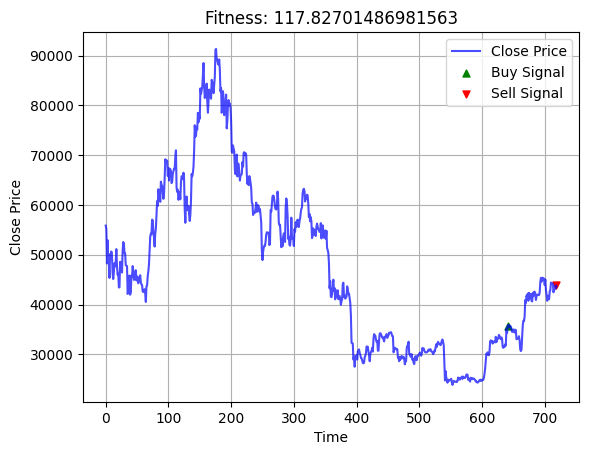

107.3047790393013


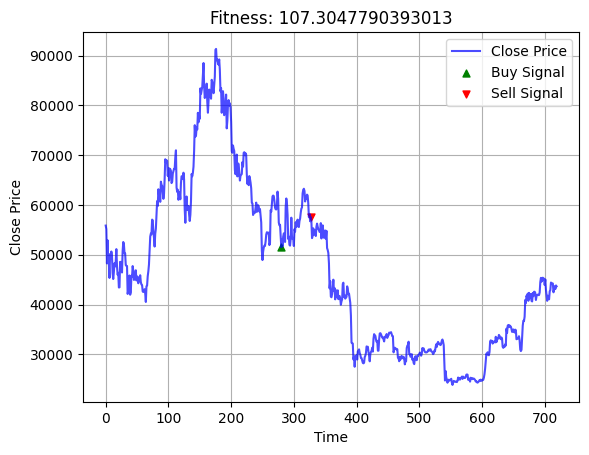

103.23886461053358


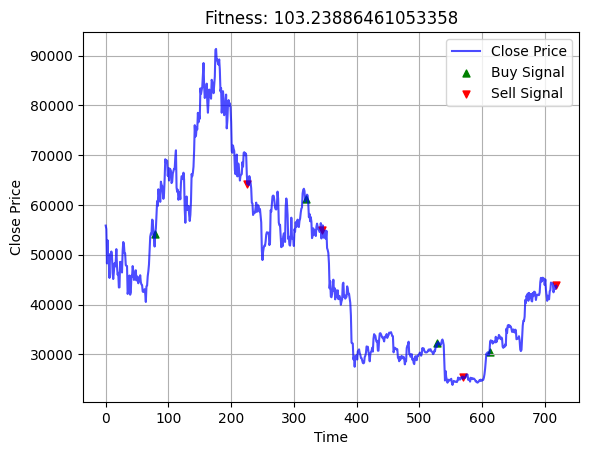

106.1199437957869


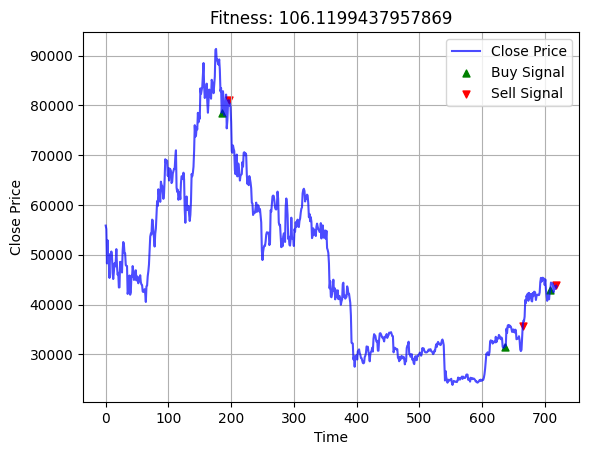

105.98694075372673


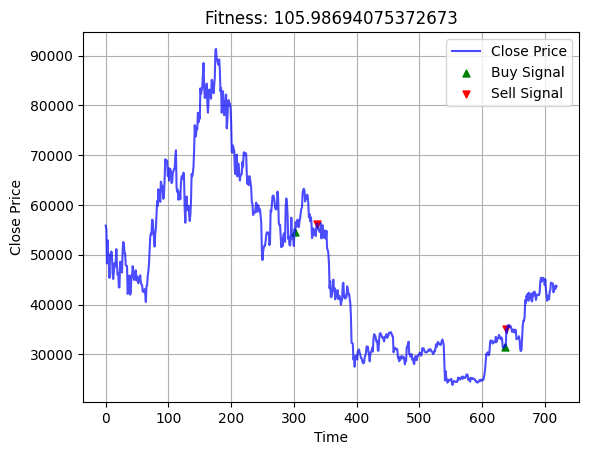

139.75007548547717


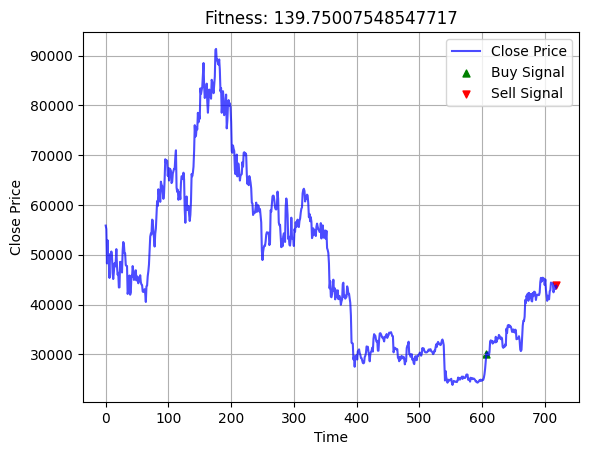

103.27787437846489


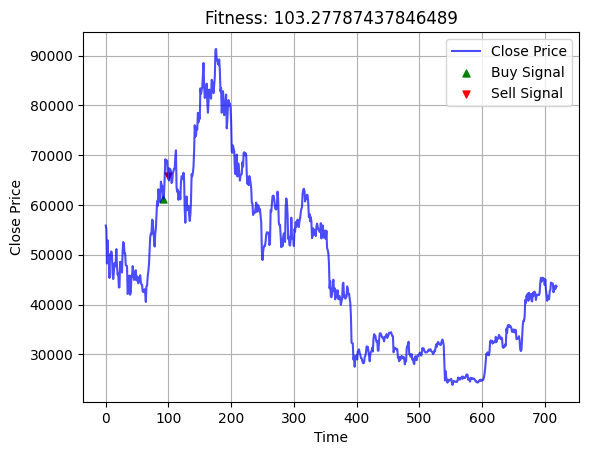

120.37667783739646


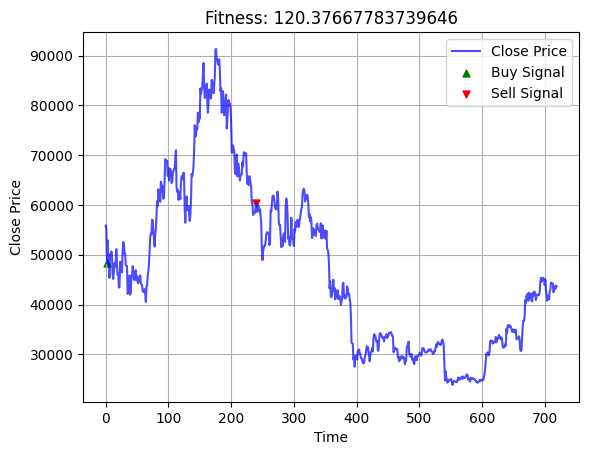

137.26199933869722


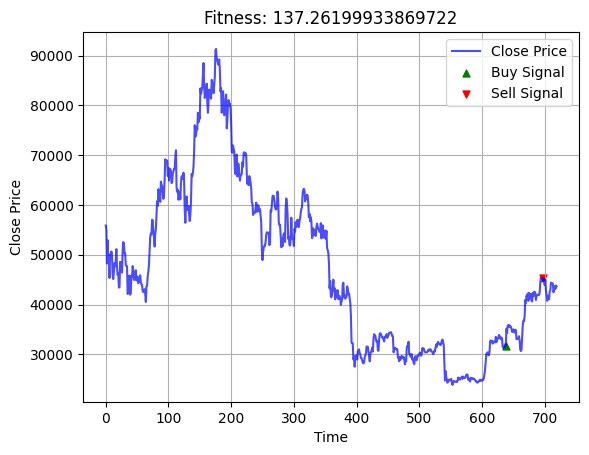

136.25824591384276


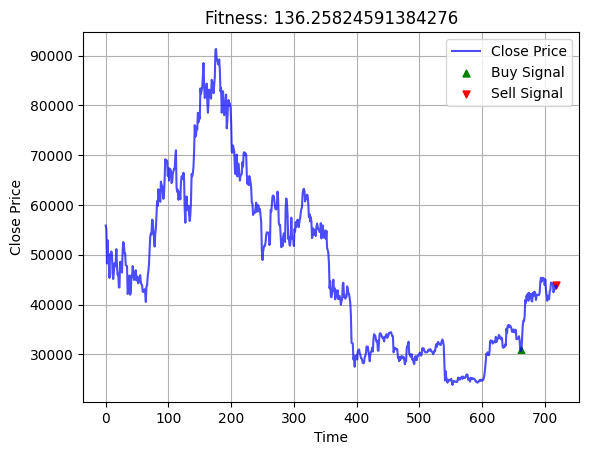

108.43501986091097


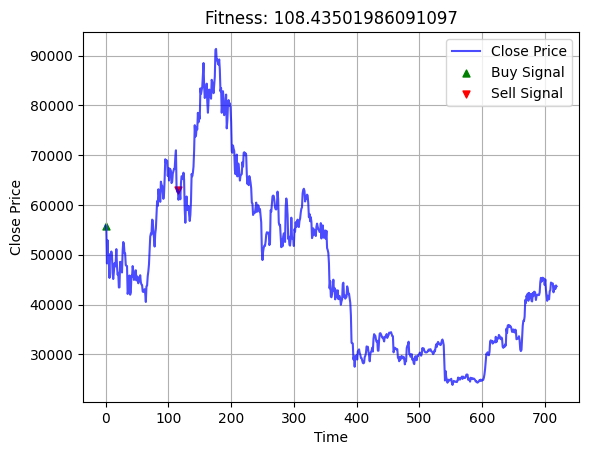

119.10628878390068


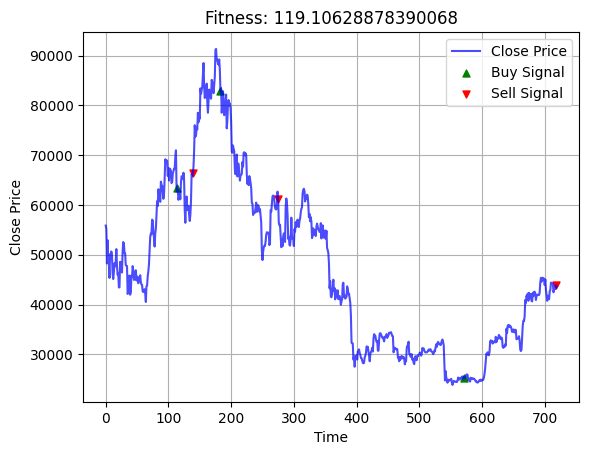

113.10807500110896


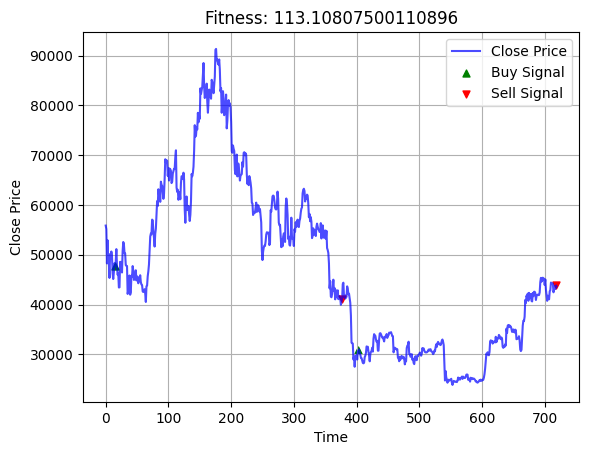

107.49801835011384


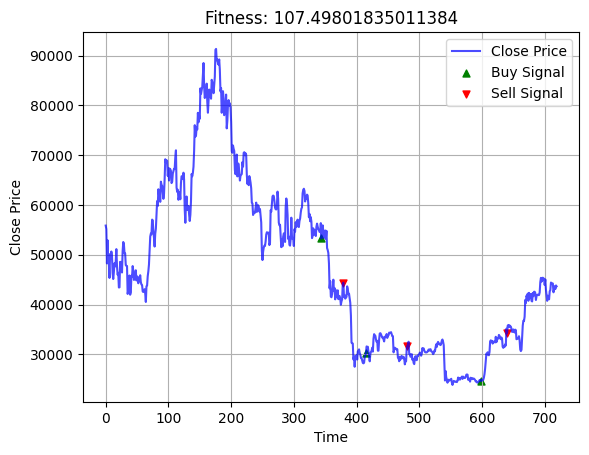

105.8703515352697


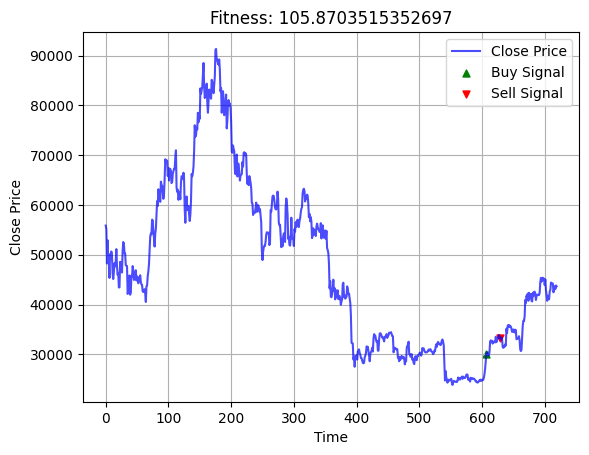

115.84277727234137


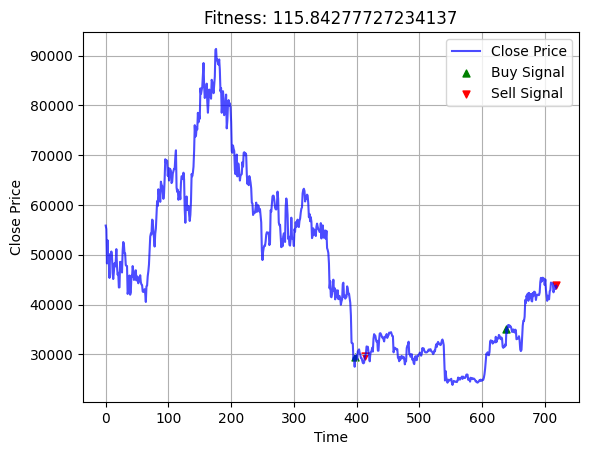

219.97444577111924


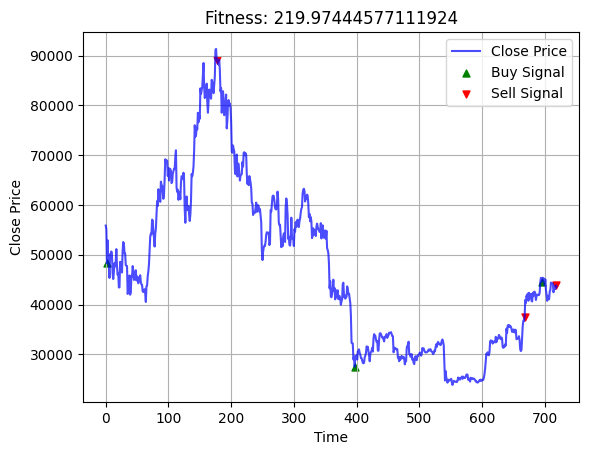

105.24311668078535


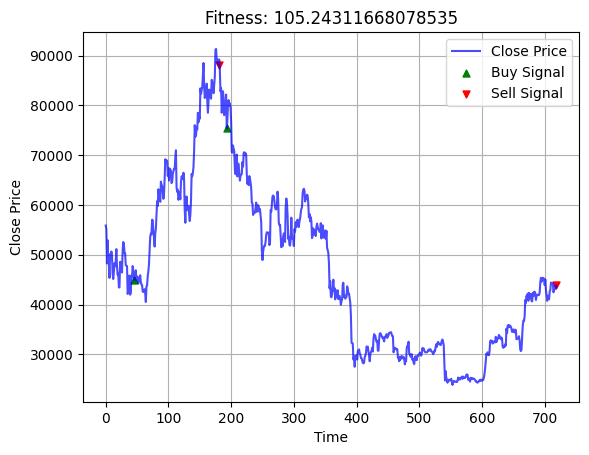

126.10782514924858


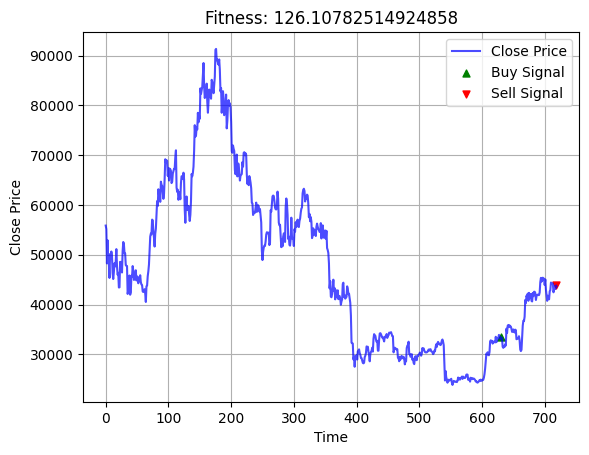

162.36422404266193


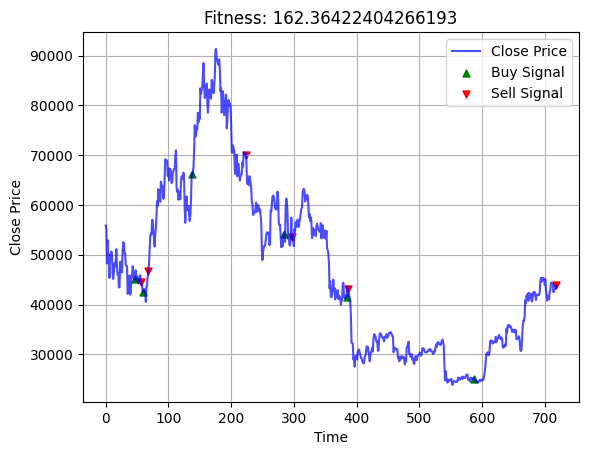

125.93539972729063


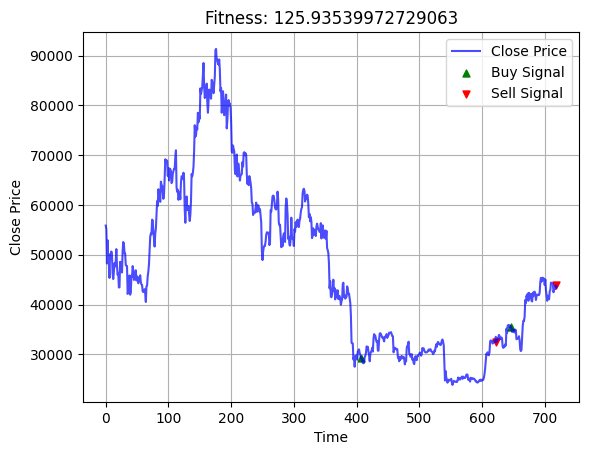

140.70805798147717


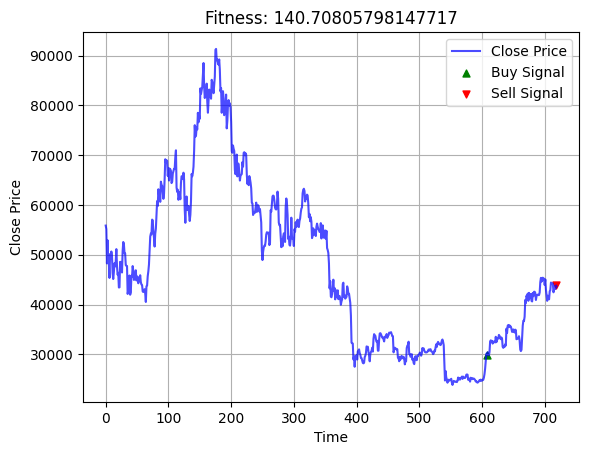

In [127]:
def numberOfEvents(positions):
    while len(positions) > 0 and positions[0][0] == 'sell':
        positions.pop(0)
    if len(positions) > 0:
        trimmed = [positions[0]]
        for i in range(1, len(positions)):
            if positions[i][0] != positions[i-1][0]:
                trimmed.append(positions[i])
    else:
        return positions
    return trimmed

for gene in goodGeneList:
    positions, fiat_money, btc_money = trading_bot(gene, ohlcv_data, from_day=0, to_day=719)
    #print(positions)
    positions = numberOfEvents(positions)



    print(fiat_money + (btc_money * ohlcv_data.iloc[-1]['c']))
    import matplotlib.pyplot as plt

    # Extract the timestamps, close prices, and buy/sell signals
    timestamps = ohlcv_data.index
    close_prices = ohlcv_data['c']
    buy_signals = [t for action, t in positions if action == 'buy']
    sell_signals = [t for action, t in positions if action == 'sell']

    # Plot the price data
    plt.plot(timestamps, close_prices, label='Close Price', color='blue', alpha=0.7)

    # Plot the buy signals
    plt.scatter([timestamps[t] for t in buy_signals],
                [close_prices[t] for t in buy_signals],
                color='g', s=25, marker="^", label='Buy Signal')

    # Plot the sell signals
    plt.scatter([timestamps[t] for t in sell_signals],
                [close_prices[t] for t in sell_signals],
                color='r', s=25, marker="v", label='Sell Signal')

    # Customize the plot appearance

    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.title(f"Fitness: {fiat_money}")
    plt.legend()
    plt.grid()

    # Show the plot
    plt.show()